In [456]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [457]:
# red convolucional para clasificar equipos en base a un ranking

# equipos en posiciones 1 a 4 -> 1 
# equipos en posiciones 5 a 8 -> 2
# equipos en posiciones 9 a 12 -> 3
# equipos en posiciones 13 a 16 -> 4
# equipos en posiciones 17 a 20 -> 5

# el input son 5 matrices y el numero en la tabla de posiciones:
# [matriz 1, matriz 2, matriz 3, matriz 4, matriz 5, posicion]

In [458]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [459]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [460]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [461]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [462]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [463]:
teams_list = df['home_team_name'].unique()

In [464]:
teams_list

array(['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur'], dtype=object)

In [465]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_initial_11(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [466]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [467]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [468]:
teams = list(team_matrixes.keys())
features = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']
X = np.array([[team_matrixes[team][feature] for feature in features] for team in teams])

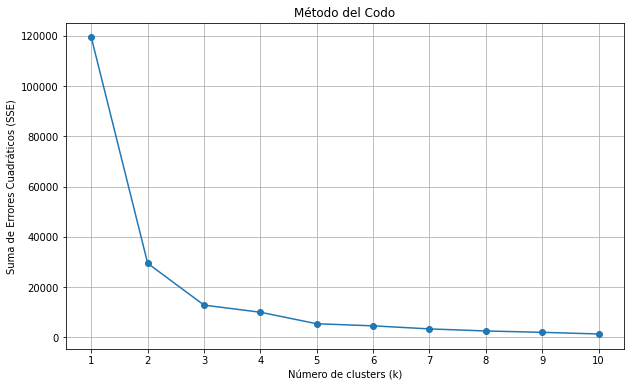

In [469]:
k_values = range(1, 11)  
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_values)
plt.grid()
plt.show()

In [470]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

team_clusters = {team: cluster for team, cluster in zip(teams, clusters)}
print(team_clusters)


{'Arsenal': np.int32(1), 'Everton': np.int32(2), 'Fulham': np.int32(2), 'Manchester City': np.int32(1), 'Newcastle United': np.int32(2), 'Queens Park Rangers': np.int32(0), 'Reading': np.int32(0), 'West Bromwich Albion': np.int32(0), 'West Ham United': np.int32(0), 'Wigan Athletic': np.int32(2), 'Aston Villa': np.int32(0), 'Chelsea': np.int32(1), 'Liverpool': np.int32(1), 'Manchester United': np.int32(1), 'Norwich City': np.int32(0), 'Southampton': np.int32(2), 'Stoke City': np.int32(0), 'Sunderland': np.int32(0), 'Swansea City': np.int32(1), 'Tottenham Hotspur': np.int32(2)}


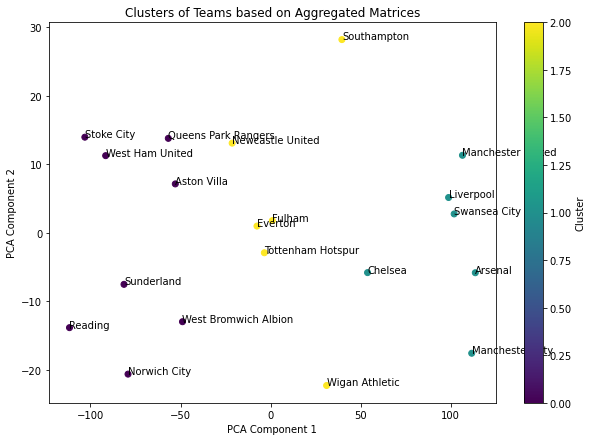

In [471]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
for i, team in enumerate(teams):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], team)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Teams based on Aggregated Matrices')
plt.colorbar(label='Cluster')
plt.show()

In [472]:
ranking_data = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')  

In [473]:
clusters_df = pd.DataFrame(list(team_clusters.items()), columns=['Equipo', 'Cluster'])
merged_data = pd.merge(ranking_data, clusters_df, on='Equipo', how='left')

In [474]:
merged_data

,Equipo,Posicion,Puntos,Cluster
0,Manchester United,1,89,1
1,Manchester City,2,78,1
2,Chelsea,3,75,1
3,Arsenal,4,73,1
4,Tottenham Hotspur,5,72,2
5,Everton,6,63,2
6,Liverpool,7,61,1
7,West Bromwich Albion,8,49,0
8,Swansea City,9,46,1
9,West Ham United,10,46,0


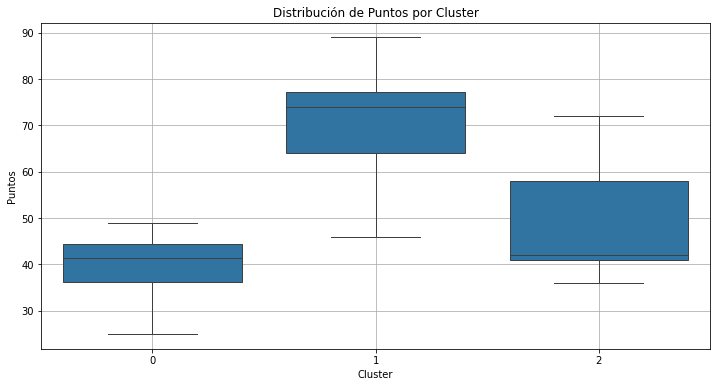

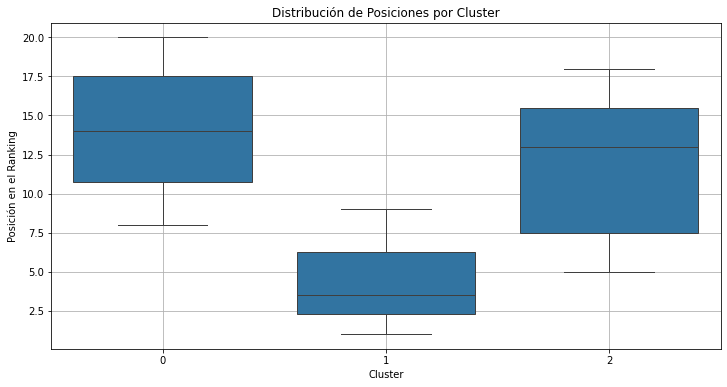

In [475]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Puntos', data=merged_data)
plt.title('Distribución de Puntos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Puntos')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Posicion', data=merged_data)
plt.title('Distribución de Posiciones por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Posición en el Ranking')
plt.grid()
plt.show()


Updated team clusters: {'Arsenal': np.int32(1), 'Everton': np.int32(2), 'Fulham': np.int32(2), 'Manchester City': np.int32(1), 'Newcastle United': np.int32(2), 'Queens Park Rangers': np.int32(0), 'Reading': np.int32(0), 'West Bromwich Albion': np.int32(0), 'West Ham United': np.int32(0), 'Wigan Athletic': np.int32(2), 'Aston Villa': np.int32(0), 'Chelsea': np.int32(1), 'Liverpool': np.int32(1), 'Manchester United': np.int32(1), 'Norwich City': np.int32(0), 'Southampton': np.int32(2), 'Stoke City': np.int32(0), 'Sunderland': np.int32(0), 'Swansea City': np.int32(1), 'Tottenham Hotspur': np.int32(2)}


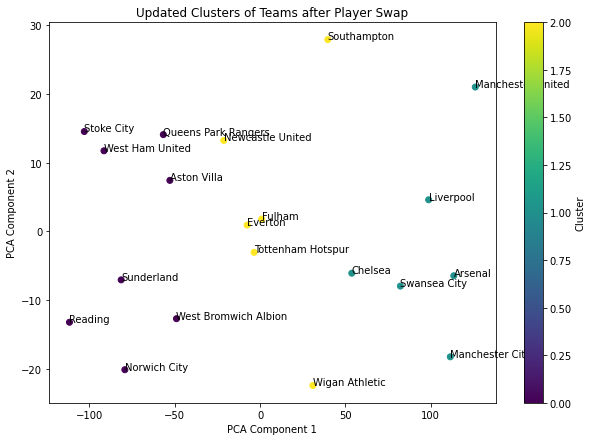

In [476]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def swap_players(team1, player1, team2, player2):
    for matrix_type in team_matrixes[team1]:
        team_matrixes[team1][matrix_type] -= np.sum(load_player_matrix(team1, player1, matrix_type)*90)
        team_matrixes[team1][matrix_type] += np.sum(load_player_matrix(team2, player2, matrix_type) * 90)
    
    for matrix_type in team_matrixes[team2]:
        team_matrixes[team2][matrix_type] -= np.sum(load_player_matrix(team2, player2, matrix_type)*90)
        team_matrixes[team2][matrix_type] += np.sum(load_player_matrix(team1, player1, matrix_type)*90)

swap_players('Manchester United', 'van Persie, Robin', 'Swansea City', 'Williams, Ashley')

teams = list(team_matrixes.keys())
features = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']
X = np.array([[team_matrixes[team][feature] for feature in features] for team in teams])

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Update team clusters
team_clusters = {team: cluster for team, cluster in zip(teams, clusters)}
print("Updated team clusters:", team_clusters)

# PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot updated clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
for i, team in enumerate(teams):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], team)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Updated Clusters of Teams after Player Swap')
plt.colorbar(label='Cluster')
plt.show()

## Player level

In [477]:
features = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix', 'cards', 'time']
X_player = np.array([[player_matrixes[player][feature] for feature in features] for player in all_players])

In [478]:
player_matrixes

{'Cazorla, Santiago': {'pass_matrix': np.float64(56.60181),
  'shot_matrix': np.float64(3.02211),
  'defense_matrix': np.float64(10.14408),
  'goal_matrix': np.float64(0.3153600000000001),
  'errors_matrix': np.float64(3.7580399999999994),
  'out_matrix': np.float64(2.81196),
  'position': 'Midfielder',
  'cards': np.float64(0.026277372262772998),
  'time': np.float64(38.05555555555556)},
 'Mertesacker, Per': {'pass_matrix': np.float64(43.94241),
  'shot_matrix': np.float64(0.47952000000000006),
  'defense_matrix': np.float64(10.52028),
  'goal_matrix': np.float64(0.08451),
  'errors_matrix': np.float64(4.3151399999999995),
  'out_matrix': np.float64(1.35297),
  'position': 'Defender',
  'cards': np.float64(0.112817298652452),
  'time': np.float64(35.455555555555556)},
 'Arteta, Mikel': {'pass_matrix': np.float64(73.21698),
  'shot_matrix': np.float64(0.55062),
  'defense_matrix': np.float64(13.47732),
  'goal_matrix': np.float64(0.17388),
  'errors_matrix': np.float64(4.23117),
  'out

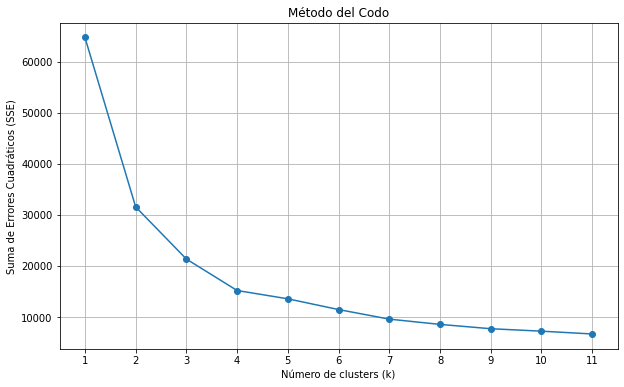

In [479]:
k_values = range(1, 12)  
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_player)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.xticks(k_values)
plt.grid()
plt.show()

In [480]:
n_clusters_player = 7

kmeans = KMeans(n_clusters=n_clusters_player, random_state=42)
clusters = kmeans.fit_predict(X_player)

player_clusters = {player: cluster for player, cluster in zip(all_players, clusters)}

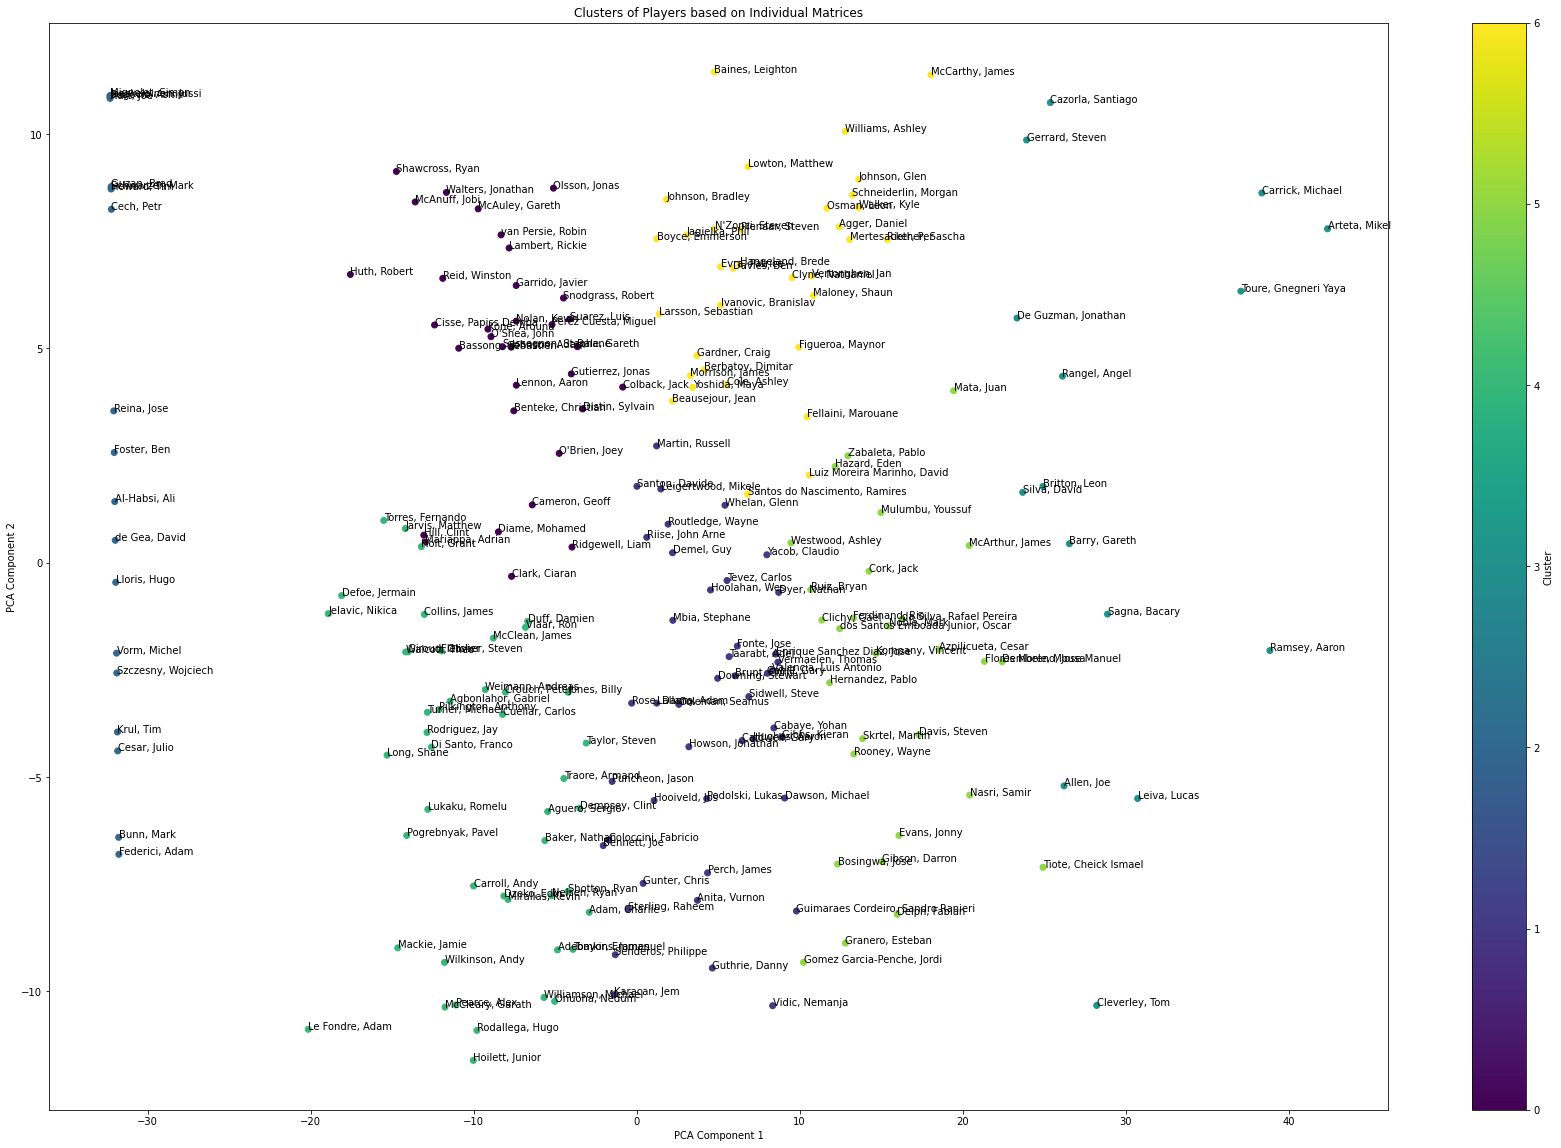

In [481]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_player)

plt.figure(figsize=(30,20))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
for i, player in enumerate(all_players):
    plt.text(X_reduced[i, 0], X_reduced[i, 1], player)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Players based on Individual Matrices')
plt.colorbar(label='Cluster')
plt.show()

In [482]:
player_df = pd.DataFrame(list(player_clusters.items()), columns=['player', 'cluster'])
player_df['position'] = player_df['player'].map(lambda player: player_matrixes[player].get('position', 'Unknown'))


In [483]:
player_df.sort_values(by='cluster', ascending=True)

,player,cluster,position
16,"Distin, Sylvain",0,Defender
55,"Hill, Clint",0,Defender
45,"Gutierrez, Jonas",0,Striker
44,"Cisse, Papiss Demba",0,Striker
101,"Kone, Arouna",0,Striker
...,...,...,...
154,"Johnson, Bradley",6,Midfielder
198,"Williams, Ashley",6,Defender
199,"Davies, Ben",6,Defender
209,"Walker, Kyle",6,Defender


In [484]:
player_df[player_df['player'] == 'van Persie, Robin']

,player,cluster,position
143,"van Persie, Robin",0,Striker


In [485]:
player_df[player_df['player'] == 'van Persie, Robin']

,player,cluster,position
143,"van Persie, Robin",0,Striker


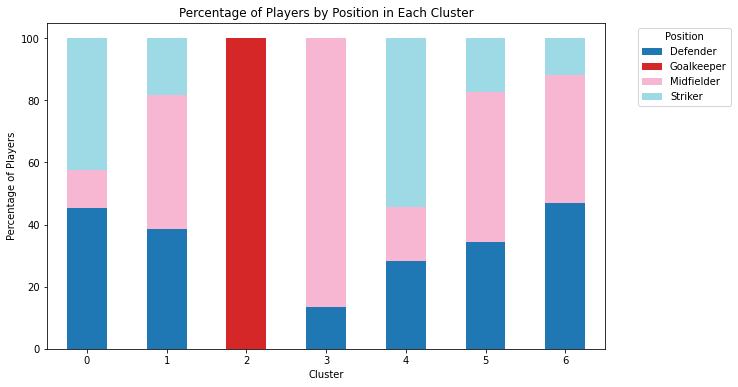

In [486]:
import matplotlib.pyplot as plt

# Sort the player DataFrame by cluster and position (if not already sorted)
player_df = player_df.sort_values(by='cluster', ascending=True)

# Calculate the count of players by cluster and position
cluster_position_counts = player_df.groupby(['cluster', 'position']).size().unstack(fill_value=0)

# Calculate the percentage of players for each position within each cluster
cluster_position_percentages = cluster_position_counts.div(cluster_position_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar plot
cluster_position_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Players')
plt.title('Percentage of Players by Position in Each Cluster')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()
